# Data Wrangling HW
In the spirit of warming up for final projects, this weeks homework will be somewhat open-ended.
Actually, it will more like closed-ended and open-middled...

Different doctors with different backgrounds, trained in different places, etc., might behave differ-
ently. In other words, one doctor might have various biases relative to another. We hope not, at
least in critical situations, but doctors are people too.

Your job is to determine whether the 4 doctors in our data set are behaving essentially the same with
respect to measuring clump thickness, bland chromatin, and diagnosis of tumor type, or whether
any one of them seems to be different.

The submission should be a pdf that makes your case as though to a boss/hospital administrator;
it should make the case in enough detail to be convincing, but not in such detail that your boss
will hate you. For example, one doctor-to-doctor comparison can be described in some detail, but
the rest can be summarized with “Similar comparisons were made for ...”

Your final conclusion should be whether 
1. everything seems okay with respect to the doctors or
2. if there are any red flags that might warrent further scrutiny.

Do the analysis with an open mind. It’s not good to enter an analysis with a pre-conceived notion
of what you may or may not find.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def bcd_load_clean():
    bcd = pd.read_csv('./data/breast_cancer_data.csv')
    bcd['patient_id'] = bcd['patient_id'].astype('string')
    bcd['doctor_name'] = bcd['doctor_name'].str.split().str[1]
    bcd['bare_nuclei'] = bcd['bare_nuclei'].replace('?', '')
    bcd['bare_nuclei'] = pd.to_numeric(bcd['bare_nuclei'])
    bcd = bcd[['clump_thickness', 'bland_chromatin', 'class', 'doctor_name']].copy()
    # add a column with 1 for cancer diagnosis and 0 for benign tumor
    cancer_diagnosis_dict = {'benign':0, 'malignant':1}
    cancer_diagnosis = bcd['class'].replace(cancer_diagnosis_dict)
    bcd.insert(3, 'cancer_diagnosis', cancer_diagnosis)
    
    return bcd

In [3]:
bcd = bcd_load_clean()

In [4]:
# peek at the dataset
bcd

,clump_thickness,bland_chromatin,class,cancer_diagnosis,doctor_name
0,5.0,3.0,benign,0,Doe
1,5.0,3.0,benign,0,Smith
2,3.0,3.0,benign,0,Lee
3,6.0,3.0,benign,0,Smith
4,4.0,3.0,benign,0,Wong
...,...,...,...,...,...
694,3.0,1.0,benign,0,Lee
695,2.0,1.0,benign,0,Smith
696,5.0,8.0,malignant,1,Lee
697,4.0,10.0,malignant,1,Lee


## Diagnosis rate per doctor
First, I must determine if any of the doctors diagnose cancer at a different rate than the others. This may indicate that the doctor has some bias in their measurement and detection of cancer, causing them to detect cancer more or less often.

In [5]:
print('Total cases per doctor:')
bcd['doctor_name'].value_counts()

Total cases per doctor:


Doe      185
Lee      181
Smith    176
Wong     157
Name: doctor_name, dtype: int64

Text(0.5, 1.0, 'Diagnosis Rates Per Doctor')

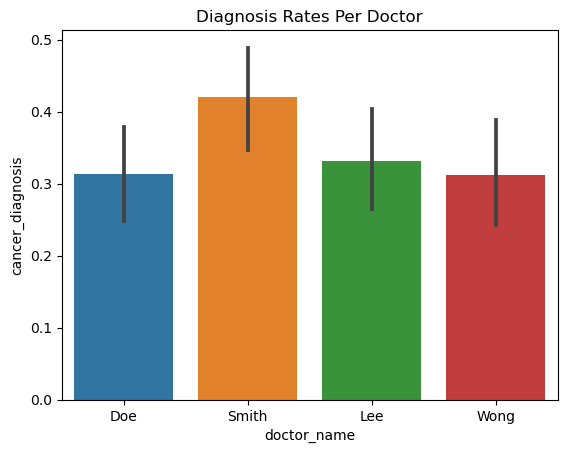

In [6]:
sns.barplot(data=bcd, y='cancer_diagnosis', x='doctor_name')
plt.title('Diagnosis Rates Per Doctor')

Smith has the highest diagnosis rate of 42%, but the diagnosis rate for the other doctors is around 31-32%. Perhaps Smith is diagnosing too many tumors as cancerous, though he could just genuinely be observing more cancerous tumors by chance. 

There are 2 different scenarios which could exist:
1. Smith is observing more cancerous tumors and correctly classifying them
2. Smith is not observing more cancerous tumors and he's incorrectly classifying them. This could be because of:
    1. inaccurate measurements that lead him to classify tumors as cancerous
    2. Inaacurate diagnostic criteria which leads him to classify a tumor as cancerous when another doctor wouldn't classify the same tumor as cancerous using the same measures

To determine which scenario is occuring, I need to:
1. Determine if he has similar diagnostic measurements as other doctors by comparing the distribution for bland chromatin and clump thickness for each doctor
2. Determine if the same relationship between bland chromatin and clump thickness in cancerous tumors is exhibtied across doctors

## Differences in Diagnostic Measurements Per Doctor

### Bland Chromatin

Text(0, 0.5, 'bland chromatin')

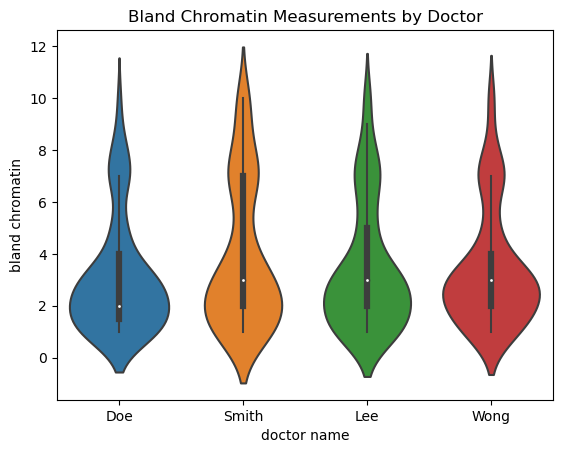

In [151]:
sns.violinplot(data=bcd, x='doctor_name', y='bland_chromatin')
plt.title('Bland Chromatin Measurements by Doctor')
plt.xlabel('doctor name')
plt.ylabel('bland chromatin')

- All the distributions for the measurements of bland chromatin by doctor follow the same relative pattern
- Doe has the smallest median bland chromatin measurement, and the median measurement for the other 3 doctors is pretty similar
- Smith has the largest IQR, and seems to have the largest spread of data with more large measurements of bland chromatin than the other doctors.

There doesn't seem to be anything indicating a doctor bias in measurement of bland chromatin since none of these distributions are glaringly different

Text(0, 0.5, 'bland chromatin')

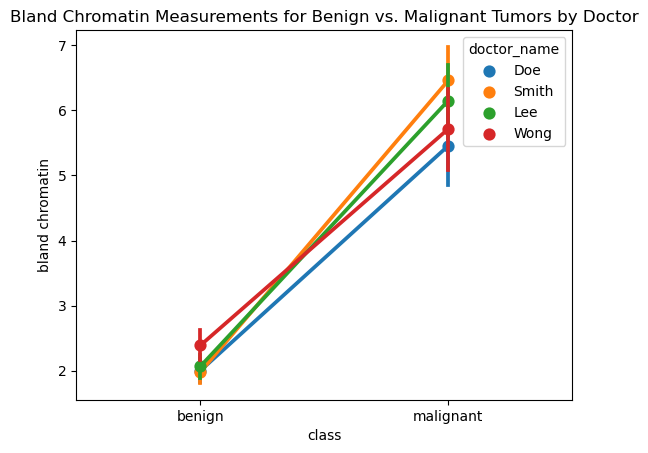

In [153]:
sns.pointplot(data=bcd, x='class', y='bland_chromatin', hue='doctor_name')
plt.title('Bland Chromatin Measurements for Benign vs. Malignant Tumors by Doctor')
plt.ylabel('bland chromatin')

Bland chromatin measurements are higher when a tumor is cancerous for all doctors. This means all of the doctors are in agreement that a tumor is more likely to be cancerous when bland chromatin is greater.

### Clump Thickness

Text(0, 0.5, 'clump thickness')

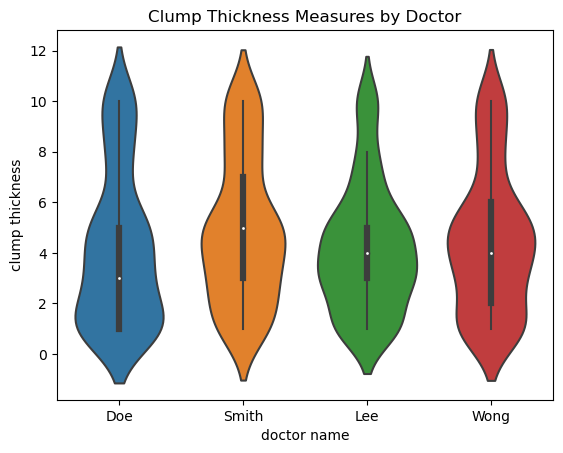

In [7]:
# boxplot of measurements for clump thickness per doctor
sns.violinplot(data=bcd, x='doctor_name', y='clump_thickness')
plt.title('Clump Thickness Measures by Doctor')
plt.xlabel('doctor name')
plt.ylabel('clump thickness')

- Once again, all of the distributions of clump thickness for the different doctors look similar. There are more observations of lesser clump thickness, but there are some tumors with greater clump thickness for all doctors.
- Doe has the smallest median, so he has slightly smaller measurements for clump thickness and bland chromatin.

These distributions don't indicate anything concerning about the way these doctors obtained tumor measurements since the distributions look relatively similar.

Text(0, 0.5, 'clump thickness')

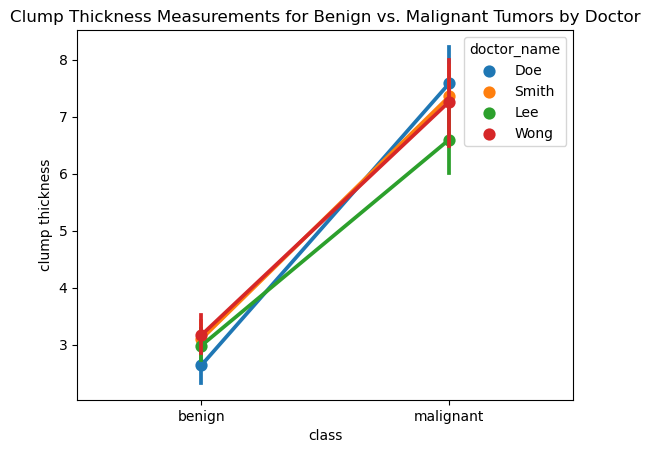

In [156]:
sns.pointplot(data=bcd, x='class', y='clump_thickness', hue='doctor_name')
plt.title('Clump Thickness Measurements for Benign vs. Malignant Tumors by Doctor')
plt.ylabel('clump thickness')

Clump thickness measurements are higher when a tumor is cancerous for all doctors. This means all of the doctors are in agreement that a tumor is more likely to be cancerous when clump thickness is greater.

## Relationship between diagnostic measures and diagnosis

**fix plot titles!**

Text(0.5, 1.05, 'Relationship Between Bland Chromatin and Clump Thickness for Malignant vs. Benign Tumors by Doctor')

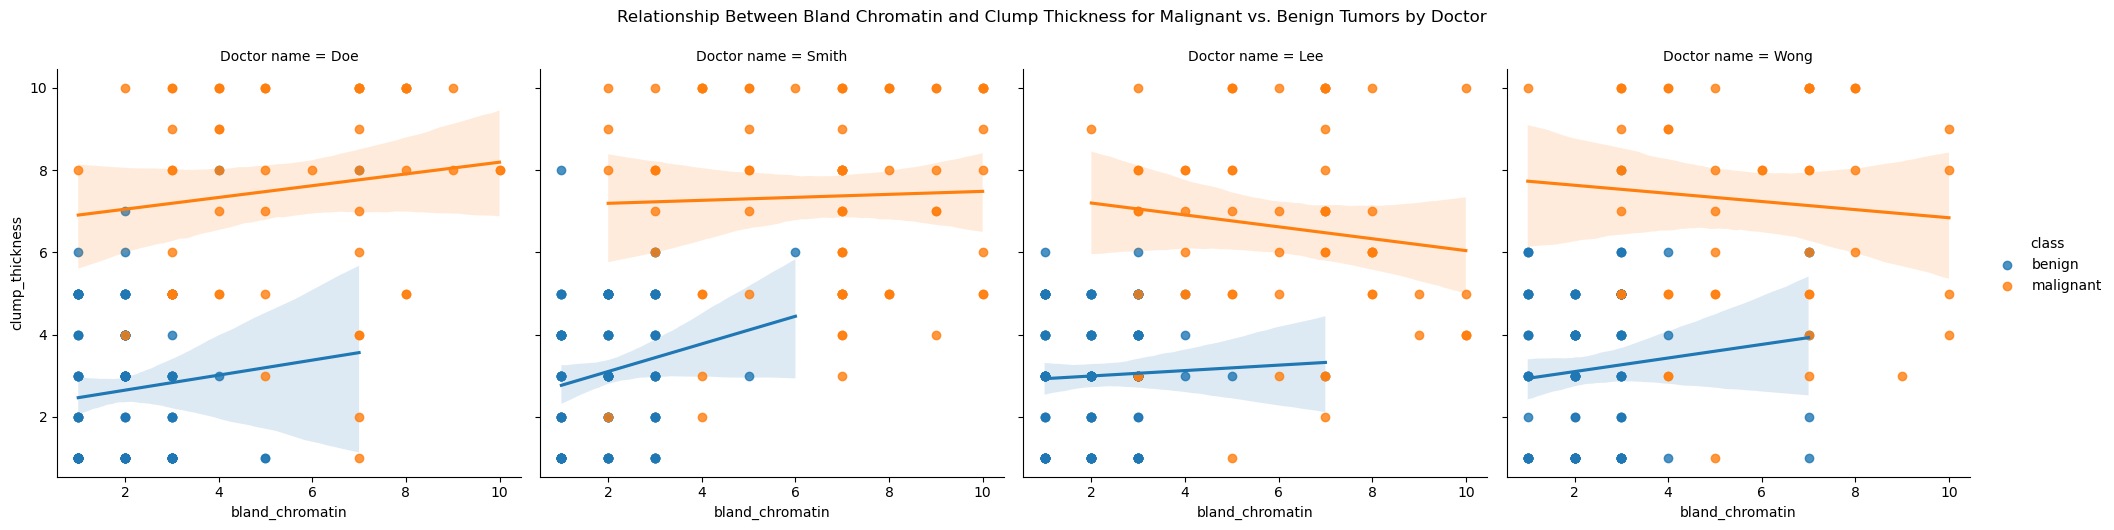

In [11]:
g = sns.lmplot(data=bcd, x='bland_chromatin', y='clump_thickness', col='doctor_name', hue='class')
g.set_titles('Doctor name = {col_name}')
g.fig.suptitle('Relationship Between Bland Chromatin and Clump Thickness for Malignant vs. Benign Tumors by Doctor', y=1.05)

All of the doctors seem to agree that clump thickness and bland chromatin measurements are greater for cancerous tumors. Additionally, clump thickness is greater at all measurements of bland chromatin for a cancerous tumor.

# Conclusion
Based on looking at the distribution of measurements for bland chromatin and clump thickness and the classification of tumors based on these measures, all of these doctors produce similar diagnostic measurements and classify cancer similarly. They consistently diagnosed tumors as cancerous when the bland chromatin and clump thicnkess measurements were greater, although there may have been some outliers for each doctor.

Although Smith has a higher rate of cancer diagnosis, they also have the greatest measurements of bland chromatin and the second greatest measurements of clump thickness on average, so they may have genuinely oberved more cancerous tumors by chance.